# Baja todos los datos de Kaggle


In [7]:
%%bash
mkdir -p ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json

mkdir kaggle_original_data
cd kaggle_original_data
kaggle competitions download -c noaa-right-whale-recognition


mkdir /content/whale_images
cd /content/whale_images
unzip -q /content/kaggle_original_data/imgs.zip


Couldn't find program: 'bash'


#Imports

In [8]:
# OS
from pathlib import Path
import os, shutil

# Data
import numpy as np
import pandas as pd 

#Imágenes
import cv2
import imagesize #Librería para ver el tamaño de una imagen sin cargarla toda en memmoria, otras como cv2 librerías cargan toda la imagen y trada mucho en procesarla

# Gáficos
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Crea los directiorios y visualiza algunos samples

In [9]:
#Estructuramos los directorios de trabajo


base_dir = './whale_images'
image_dir =  './whale_images/imgs' 
train_dir =  './whale_images/train'
validation_dir =  './whale_images/validation' 
original_data= './kaggle_original_data'

# Directorios para los splits de
# entrenamiento, validación 
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)

# Copia una imagen que faltaba en el los archivos y está en el CSV (estaba como ejjemplo en la raiz)
src = os.path.join(original_data, 'w_7489.jpg')
dst = os.path.join(image_dir, 'w_7489.jpg')
shutil.copyfile(src, dst)




FileNotFoundError: [Errno 2] No such file or directory: './kaggle_original_data\\w_7489.jpg'

width=2960, height=1974, depth=3


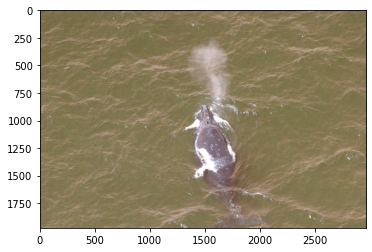

width=2989, height=1993, depth=3


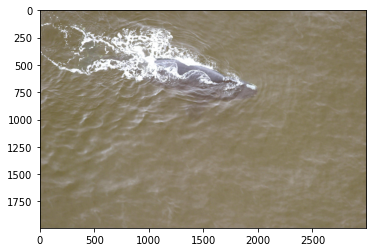

width=2464, height=1648, depth=3


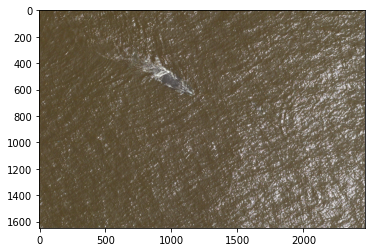

width=3186, height=2124, depth=3


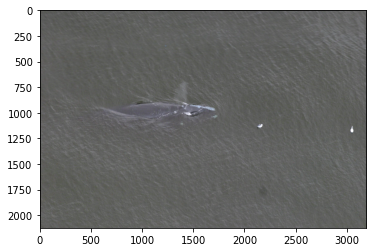

width=3072, height=2048, depth=3


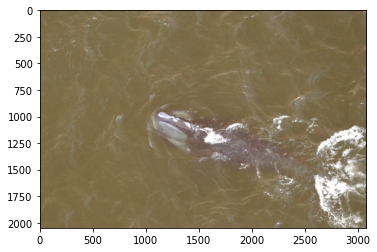

In [4]:

# Elegimos 5 imágenes
random_whales = [os.path.join(image_dir, fname)
               for fname in np.random.choice(os.listdir(image_dir), 5)]

# Mostramos las imágenes
for whale in random_whales:
  cv_whale = cv2.imread(whale)
  plt.imshow(cv_whale)
  (h, w, d) = cv_whale.shape
  print("width={}, height={}, depth={}".format(w, h, d))
  #plt.axis('off')
  plt.show()


#Exploramos y copiamos las imágenes etiquetadas a Train

In [28]:
#Vemos cuantas bellenas
print (image_dir)
DIR = image_dir
number_of_files = len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])
print("Archivos:", number_of_files)

train_files = pd.read_csv(os.path.join(original_data  , 'train.csv')) 

# agregamos las resoluciones de las imágenes
# copiamos las etiquetadas al dir de train (despues veremos que copiamos al de validation)
# en un momento w_7489.jpg faltba del direcorio de imágenes, por eso los checks


train_files['Width']=0
train_files['Height']= 0

missing = 0
total = 0
for i, line in train_files.iterrows():
  file_name = Path(os.path.join(image_dir, line['Image'])) 
  dest_name = Path(os.path.join(train_dir, line['Image']))
  if file_name.is_file():
    w, h = imagesize.get(file_name)
    train_files.at [i,'Height']  =h
    train_files.at [i,'Width'] = w
    shutil.copyfile(file_name, dest_name)
    #print("File={}, width={}, height={}".format(line['Image'],w, h))
  else: 
    missing+=1
    print(file_name)
  total+=1
print("Etiquetadas:  Total={}, Missing={}, OK={}".format(total, missing, total-missing))

print(train_files.head())




./whale_images/imgs
Archivos: 11470
Etiquetadas:  Total=4544, Missing=0, OK=4544
        Image      whaleID  Width  Height
0  w_7812.jpg  whale_48813   3072    2048
1  w_4598.jpg  whale_09913   3072    2048
2  w_3828.jpg  whale_45062   3072    2048
3  w_8734.jpg  whale_74162   3072    2048
4  w_3251.jpg  whale_99558   3072    2048


Estos gráficos me parecieron interesantes poruqe vemos las resoluciones de las imágenes están agrupadas y a demas que la relacios entre W y H es casi siempre la misma, alrededor de 1.5. Eso quiere decir que no vamos a tener problemas de distorción si las escalamos. 

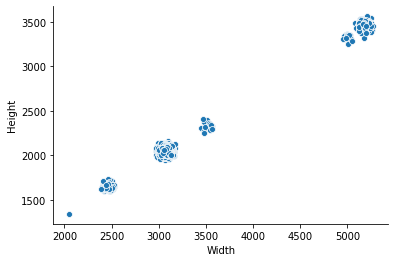

In [15]:
#Hacemos un scatterplot con Jitter para ver la resolución de la imágenes
 

def jitterize(df, mu, sigma):
  noise = np.random.normal(mu, sigma, df.shape )
  return df+noise 

df = jitterize(train_files[['Width', 'Height']], 0, 30)

sns.scatterplot (x='Width', y='Height', data=df)
sns.despine()



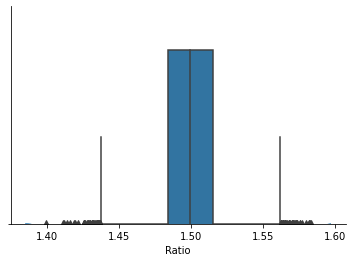

In [24]:
df ['Ratio'] = df['Width']/df['Height'] 
sns.boxplot (x='Ratio',  data=df)
sns.despine()

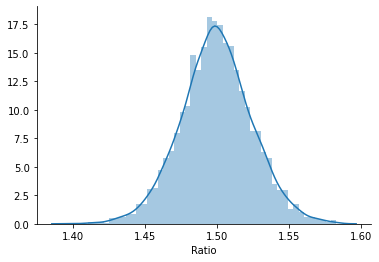

In [25]:

sns.distplot (df ['Ratio'] )
sns.despine()